#  Employee’s Performance for HR Analytics (Unsupervised Learning)

**📊 Dataset:** `Uncleaned_employees_final_dataset (1).csv`  
**📚 Source:** [Kaggle – HR Analytics: Employee Performance Dataset](https://www.kaggle.com/)  



### 🎯 Goal
Use **unsupervised learning (clustering)** to discover hidden employee groups based on demographics, performance, and experience.  
This helps HR understand workforce patterns and improve engagement and retention strategies.



### 📈 Description
By analyzing features like:
- `age`, `education`, `department`, `length_of_service`,  
- `no_of_trainings`, `previous_year_rating`, `KPIs_met_more_than_80`,  
- `awards_won`, and `avg_training_score`,  

the project identifies meaningful employee clusters to support **data-driven HR decisions**.


In [ ]:
# Phase 0: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels for VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Sklearn libraries
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# For saving models
import os
import joblib


In [2]:
# Load the dataset
df = pd.read_csv(r"D:\cs year 3\ML\Employee-Segmentation-Clustering\Data\Uncleaned_employees_final_dataset (1).csv")

# Phase 1: Data Overview & Understanding

# Data Overview

In [3]:
# Check the number of rows and columns
print("Dataset Shape:", df.shape)

Dataset Shape: (17417, 13)


In [4]:
# Display first 5 rows to understand the structure
display(df.head())

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
0,8724,Technology,region_26,Bachelors,m,sourcing,1,24,NaN,1,1,0,77
1,74430,HR,region_4,Bachelors,f,other,1,31,3.0,5,0,0,51
2,72255,Sales & Marketing,region_13,Bachelors,m,other,1,31,1.0,4,0,0,47
3,38562,Procurement,region_2,Bachelors,f,other,3,31,2.0,9,0,0,65
4,64486,Finance,region_29,Bachelors,m,sourcing,1,30,4.0,7,0,0,61


In [5]:
# Display sample 5 rows to understand the structure
display(df.sample(5))

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
32,67672,Technology,region_17,Bachelors,m,other,1,29,NaN,1,1,0,85
9847,33871,Sales & Marketing,region_24,Bachelors,m,sourcing,1,30,3.0,3,0,0,51
12645,67830,Technology,region_5,Bachelors,f,sourcing,1,36,4.0,4,0,0,79
6736,15325,Operations,region_16,Masters & above,m,sourcing,2,37,5.0,9,0,1,74
15983,32185,Procurement,region_8,Bachelors,m,sourcing,1,32,3.0,3,0,0,68


In [6]:
# View dataset information (column types and null values)
print("\nDataset Info:")
df.info()


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17417 entries, 0 to 17416
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   employee_id            17417 non-null  int64  
 1   department             17417 non-null  object 
 2   region                 17417 non-null  object 
 3   education              16646 non-null  object 
 4   gender                 17417 non-null  object 
 5   recruitment_channel    17417 non-null  object 
 6   no_of_trainings        17417 non-null  int64  
 7   age                    17417 non-null  int64  
 8   previous_year_rating   16054 non-null  float64
 9   length_of_service      17417 non-null  int64  
 10  KPIs_met_more_than_80  17417 non-null  int64  
 11  awards_won             17417 non-null  int64  
 12  avg_training_score     17417 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 1.7+ MB


In [7]:
# Summary of numerical features
print("\nNumerical Summary:")
display(df.describe().T)


Numerical Summary:


,count,mean,std,min,25%,50%,75%,max
employee_id,17417.0,39083.491129,22707.024087,3.0,19281.0,39122.0,58838.0,78295.0
no_of_trainings,17417.0,1.250732,0.595692,1.0,1.0,1.0,1.0,9.0
age,17417.0,34.807774,7.694046,20.0,29.0,33.0,39.0,60.0
previous_year_rating,16054.0,3.345459,1.265386,1.0,3.0,3.0,4.0,5.0
length_of_service,17417.0,5.801860,4.175533,1.0,3.0,5.0,7.0,34.0
KPIs_met_more_than_80,17417.0,0.358845,0.479675,0.0,0.0,0.0,1.0,1.0
awards_won,17417.0,0.023368,0.151074,0.0,0.0,0.0,0.0,1.0
avg_training_score,17417.0,63.176322,13.418179,39.0,51.0,60.0,75.0,99.0


In [8]:
# Summary of categorical features
print("\nCategorical Summary:")
display(df.describe(include='object').T)


Categorical Summary:


,count,unique,top,freq
department,17417,9,Sales & Marketing,5458
region,17417,34,region_2,3918
education,16646,3,Bachelors,11519
gender,17417,2,m,12314
recruitment_channel,17417,3,other,9751


# Data Understanding

In [9]:
# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=['int64', 'float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns
print("\nNumerical Columns:", num_cols.tolist())
print("Categorical Columns:", cat_cols.tolist())


Numerical Columns: ['employee_id', 'no_of_trainings', 'age', 'previous_year_rating', 'length_of_service', 'KPIs_met_more_than_80', 'awards_won', 'avg_training_score']
Categorical Columns: ['department', 'region', 'education', 'gender', 'recruitment_channel']


In [10]:
# Count unique values per column
print("\nUnique Values per Column:")
display(df.nunique().to_frame('Unique Values').T)


Unique Values per Column:


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
Unique Values,17414,9,34,3,2,3,9,41,5,34,2,2,61


In [13]:
df.describe().T


,count,mean,std,min,25%,50%,75%,max
employee_id,17417.0,39083.491129,22707.024087,3.0,19281.0,39122.0,58838.0,78295.0
no_of_trainings,17417.0,1.250732,0.595692,1.0,1.0,1.0,1.0,9.0
age,17417.0,34.807774,7.694046,20.0,29.0,33.0,39.0,60.0
previous_year_rating,16054.0,3.345459,1.265386,1.0,3.0,3.0,4.0,5.0
length_of_service,17417.0,5.801860,4.175533,1.0,3.0,5.0,7.0,34.0
KPIs_met_more_than_80,17417.0,0.358845,0.479675,0.0,0.0,0.0,1.0,1.0
awards_won,17417.0,0.023368,0.151074,0.0,0.0,0.0,0.0,1.0
avg_training_score,17417.0,63.176322,13.418179,39.0,51.0,60.0,75.0,99.0


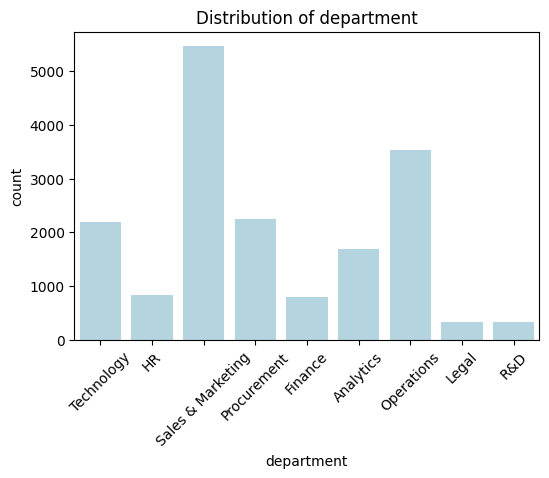

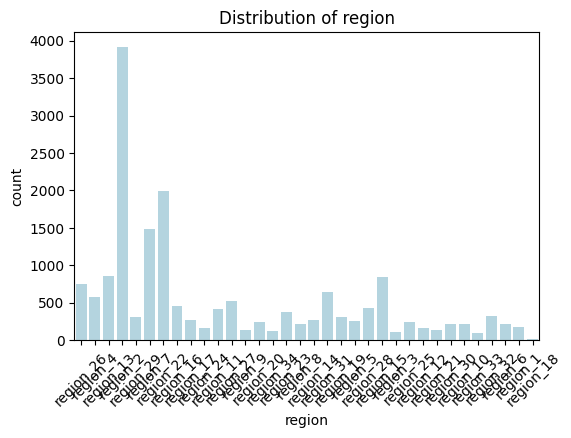

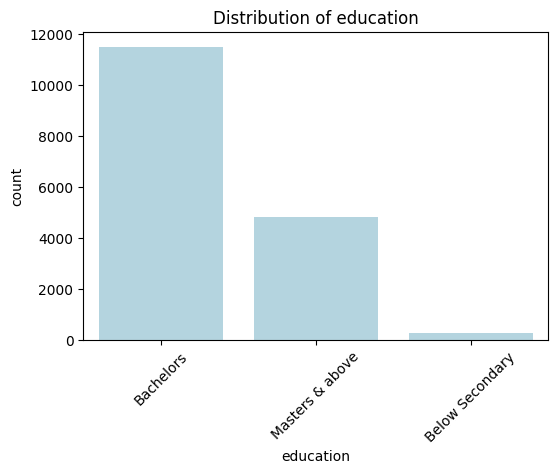

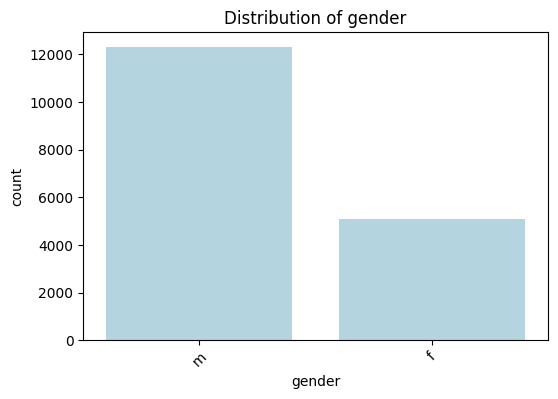

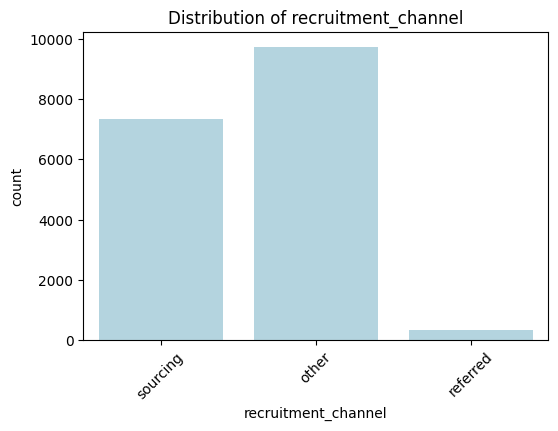

In [14]:
# Visualize first few categorical columns
for col in cat_cols[:5]:  
    plt.figure(figsize=(6, 4))
    sns.countplot(x=col, data=df, color='lightblue')  
    plt.title(f"Distribution of {col}")
    plt.xticks(rotation=45)
    plt.show()

In [15]:
# Display the number of numerical and categorical columns
print(f"✅ Total Numerical Columns: {len(num_cols)}")
print(f"✅ Total Categorical Columns: {len(cat_cols)}")

✅ Total Numerical Columns: 8
✅ Total Categorical Columns: 5


#  Phase 2: Data Cleaning

In [20]:
# Check for Missing Values
print("🔹 Missing Values per Column:")
df.isna().sum()


🔹 Missing Values per Column:


employee_id                 0
department                  0
region                      0
education                 771
gender                      0
recruitment_channel         0
no_of_trainings             0
age                         0
previous_year_rating     1363
length_of_service           0
KPIs_met_more_than_80       0
awards_won                  0
avg_training_score          0
dtype: int64

Handle Missing Values

In [21]:
df[df['education'].isna()]


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
49,3720,Sales & Marketing,region_2,NaN,m,sourcing,1,36,5.0,4,1,0,49
67,26977,Operations,region_2,NaN,m,sourcing,1,28,3.0,3,0,0,59
89,2347,Analytics,region_15,NaN,m,other,2,37,5.0,8,1,0,82
127,42719,Analytics,region_21,NaN,m,sourcing,1,27,NaN,1,0,0,80
138,2721,Analytics,region_22,NaN,f,sourcing,2,26,5.0,3,1,0,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17334,72527,Analytics,region_32,NaN,m,sourcing,1,26,3.0,1,1,0,81
17348,47420,Sales & Marketing,region_2,NaN,m,sourcing,1,28,2.0,7,0,0,48
17354,49841,Analytics,region_22,NaN,m,sourcing,1,28,3.0,6,0,0,90
17373,42917,Sales & Marketing,region_14,NaN,m,other,1,24,NaN,1,0,0,50


In [22]:
df[df['previous_year_rating'].isna()]


,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
0,8724,Technology,region_26,Bachelors,m,sourcing,1,24,NaN,1,1,0,77
21,5677,Technology,region_17,Bachelors,m,sourcing,1,25,NaN,1,0,0,80
32,67672,Technology,region_17,Bachelors,m,other,1,29,NaN,1,1,0,85
39,55325,Analytics,region_22,Bachelors,m,other,1,25,NaN,1,0,0,88
47,44159,Analytics,region_22,Masters & above,m,other,1,31,NaN,1,1,0,84
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17344,15200,Analytics,region_26,Bachelors,m,other,1,28,NaN,1,1,0,86
17358,2142,HR,region_22,Bachelors,m,referred,1,30,NaN,1,0,0,46
17373,42917,Sales & Marketing,region_14,NaN,m,other,1,24,NaN,1,0,0,50
17384,74428,Sales & Marketing,region_5,Bachelors,f,other,1,27,NaN,1,0,0,47


In [24]:
df.dropna(inplace=True)


In [25]:
# Verify that missing values are handled
print("✅ Missing values after filling:")
print(df.isnull().sum())

✅ Missing values after filling:
employee_id              0
department               0
region                   0
education                0
gender                   0
recruitment_channel      0
no_of_trainings          0
age                      0
previous_year_rating     0
length_of_service        0
KPIs_met_more_than_80    0
awards_won               0
avg_training_score       0
dtype: int64


In [26]:
df.shape


(15424, 13)

Check for Duplicates

In [17]:
print("\n🔹 Number of duplicate rows:")
df.duplicated().sum()


🔹 Number of duplicate rows:


np.int64(2)

 Remove duplicate rows

In [27]:
duplicate = df[df.duplicated()]
 
duplicate

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
17414,49584,HR,region_7,Bachelors,m,other,1,33,1.0,9,0,0,51
17415,49584,HR,region_7,Bachelors,m,other,1,33,1.0,9,0,0,51


In [28]:
df.drop_duplicates(inplace=True)

In [29]:
df.drop(columns=['employee_id'], inplace=True)


In [30]:
df.department.value_counts()


department
Sales & Marketing    4601
Operations           3284
Procurement          2077
Technology           1984
Analytics            1436
HR                    738
Finance               716
R&D                   299
Legal                 287
Name: count, dtype: int64

In [31]:
df.region.value_counts()


region
region_2     3421
region_22    1659
region_7     1330
region_13     805
region_15     764
region_26     653
region_31     575
region_4      544
region_27     452
region_16     396
region_11     388
region_28     383
region_23     354
region_19     299
region_29     281
region_17     247
region_14     246
region_32     238
region_25     227
region_20     222
region_5      222
region_10     200
region_6      190
region_8      190
region_30     182
region_24     152
region_1      150
region_12     134
region_34     113
region_21     107
region_3      101
region_9       99
region_33      86
region_18      12
Name: count, dtype: int64

In [32]:
df.education.value_counts()


education
Bachelors          10464
Masters & above     4790
Below Secondary      168
Name: count, dtype: int64

In [33]:
df.gender.value_counts()


gender
m    10811
f     4611
Name: count, dtype: int64

In [34]:
df.recruitment_channel.value_counts()


recruitment_channel
other       8659
sourcing    6476
referred     287
Name: count, dtype: int64

In [35]:
num_col = df.select_dtypes(include=np.number)


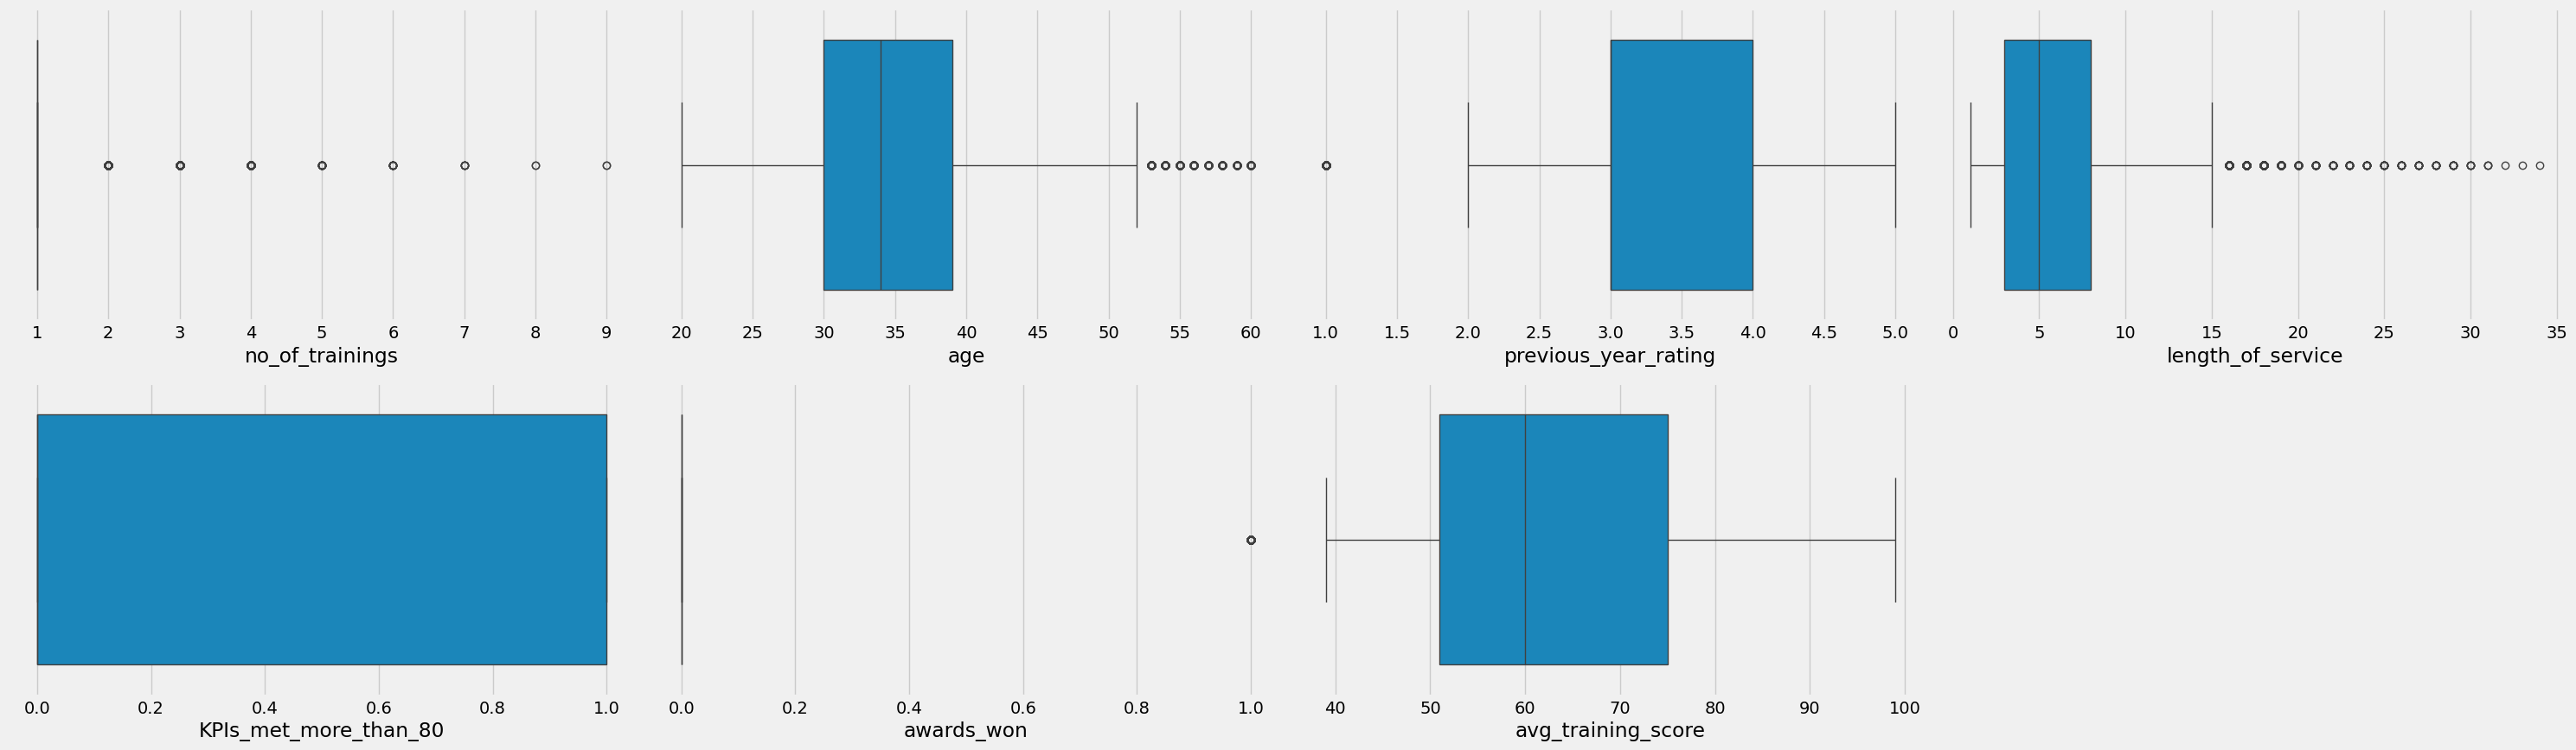

In [36]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(30,30))
for index,column in enumerate(num_col):
    plt.subplot(7,4,index+1)
    sns.boxplot(data=num_col,x=column)
    
plt.tight_layout(pad = 1.0)

# Phase 3: EDA & Data Quality

#### 🔹 Univariate Analysis

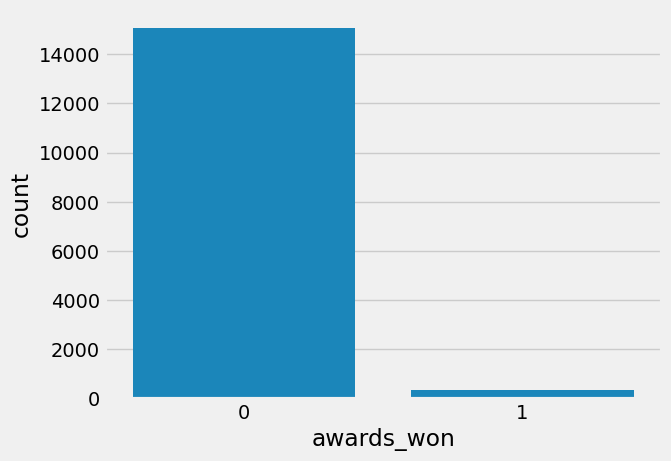

In [37]:
sns.countplot(x='awards_won', data=df)
plt.show()

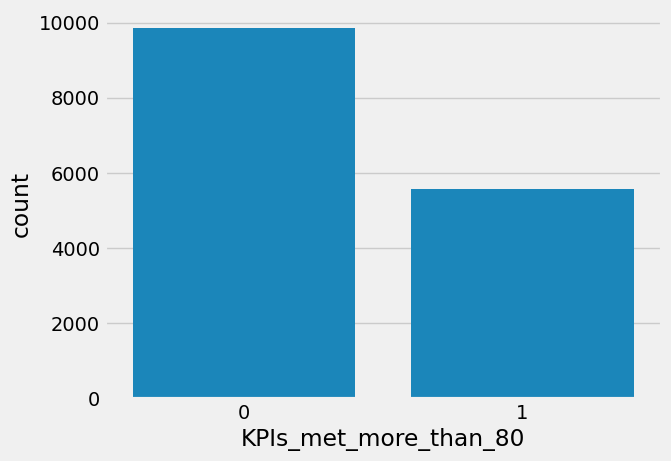

In [38]:
# 0 indicates that the employee did not meet 80% of the KPI target, 1 = met.

sns.countplot(x='KPIs_met_more_than_80', data=df)
plt.show()

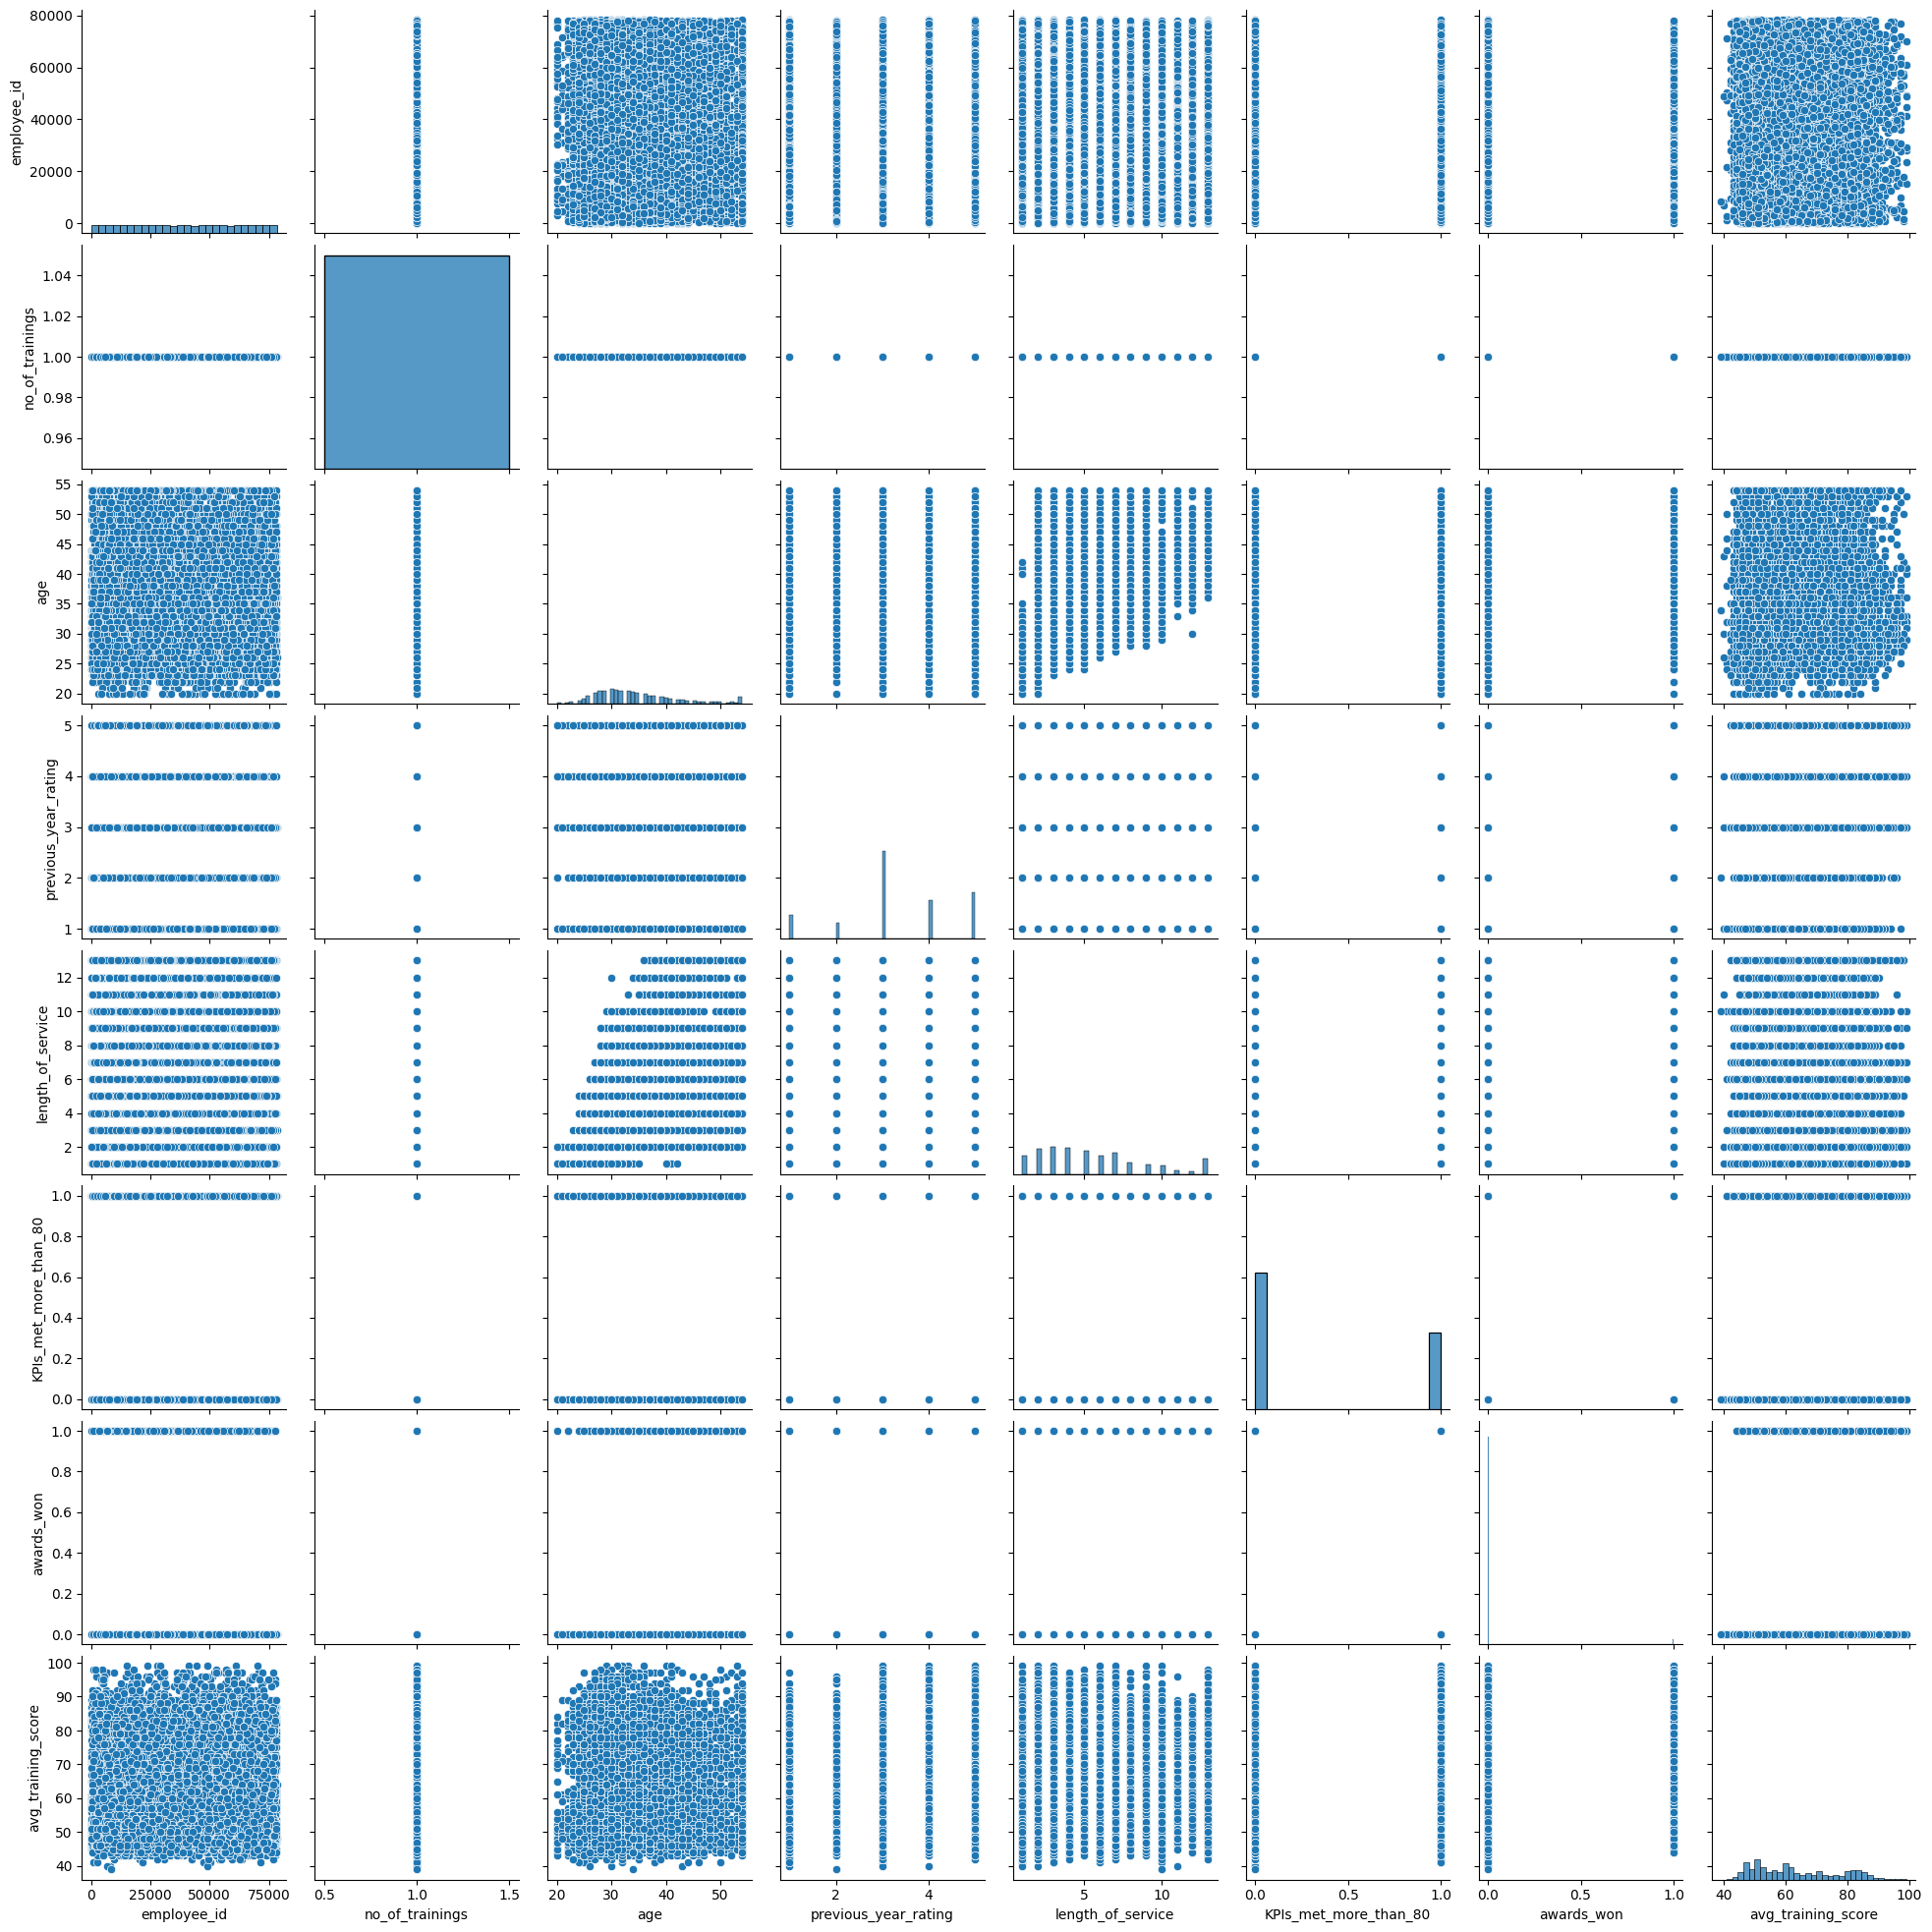

In [24]:
# Numerical pairs plot 
sns.pairplot(df[num_cols])
plt.show()


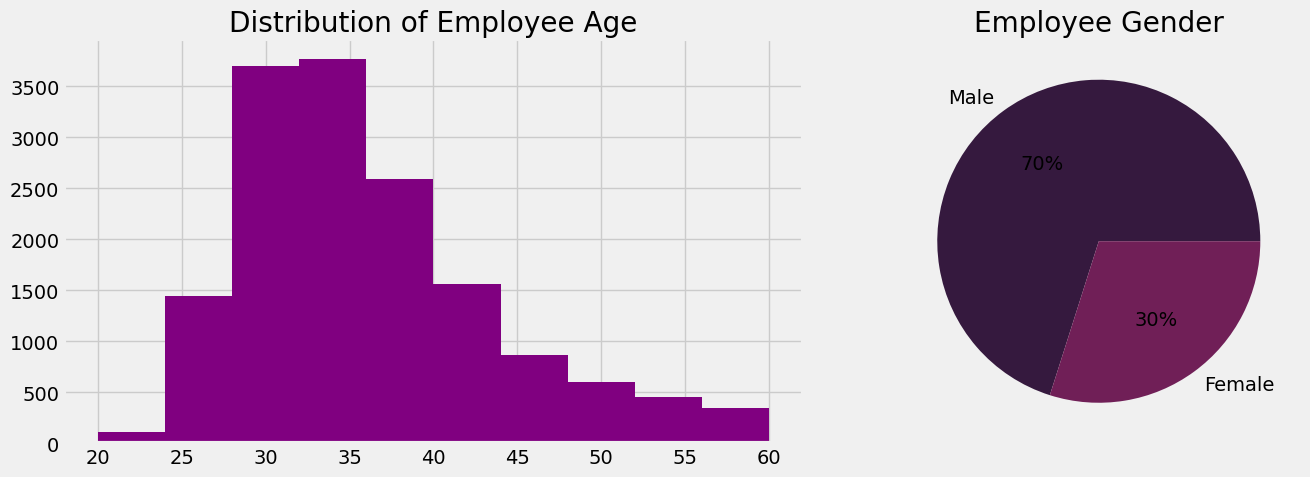

In [39]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
palette_color = sns.color_palette('rocket')
ax[0].hist(x=df['age'],color='purple')
ax[0].set_title("Distribution of Employee Age")
ax[1].pie(df['gender'].value_counts(),autopct='%1.f%%',colors=palette_color,labels=['Male','Female'])
ax[1].set_title("Employee Gender")
plt.tight_layout();

C:\Users\nadin\AppData\Local\Temp\ipykernel_32364\138209793.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  chart=sns.countplot(y='region',data=df,palette='rocket', order = df['region'].value_counts()[:20].index)


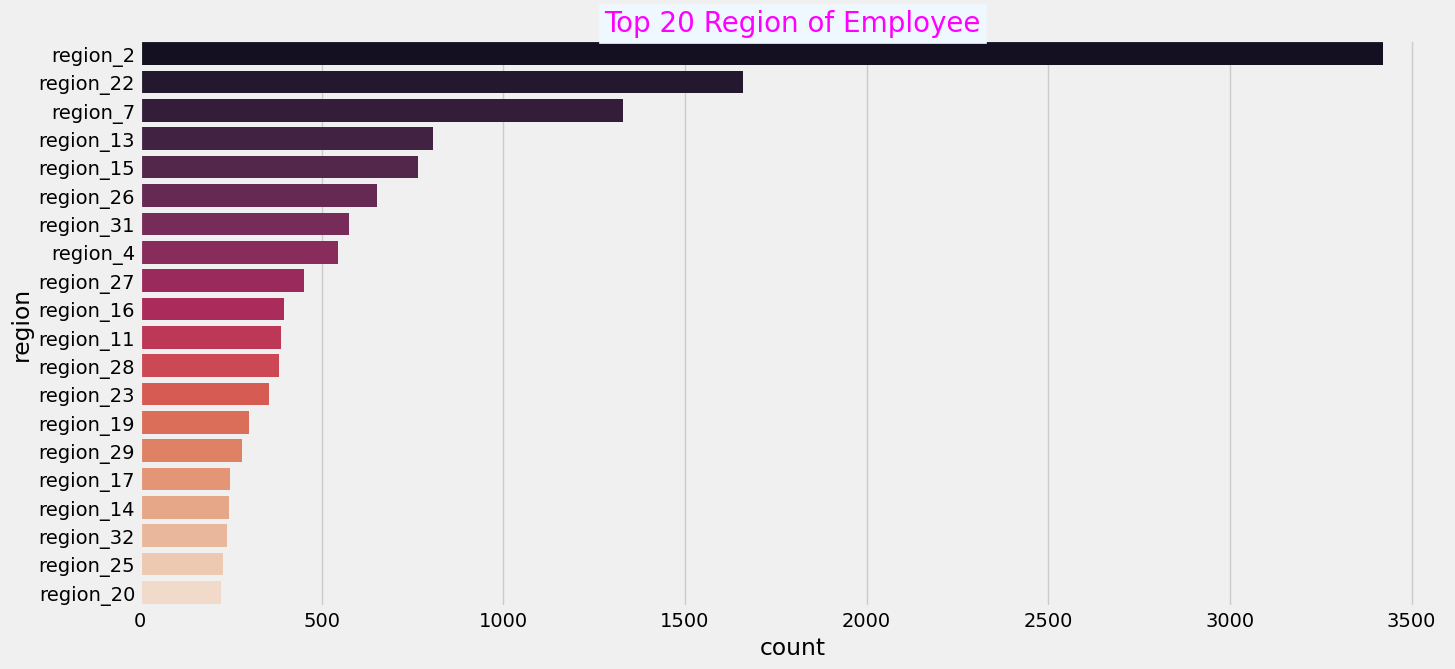

In [40]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(15,7))
chart=sns.countplot(y='region',data=df,palette='rocket', order = df['region'].value_counts()[:20].index)
plt.title("Top 20 Region of Employee",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta');

C:\Users\nadin\AppData\Local\Temp\ipykernel_32364\3421351344.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart=sns.countplot(x='department',data=df,palette='rocket', order = df['department'].value_counts().index)


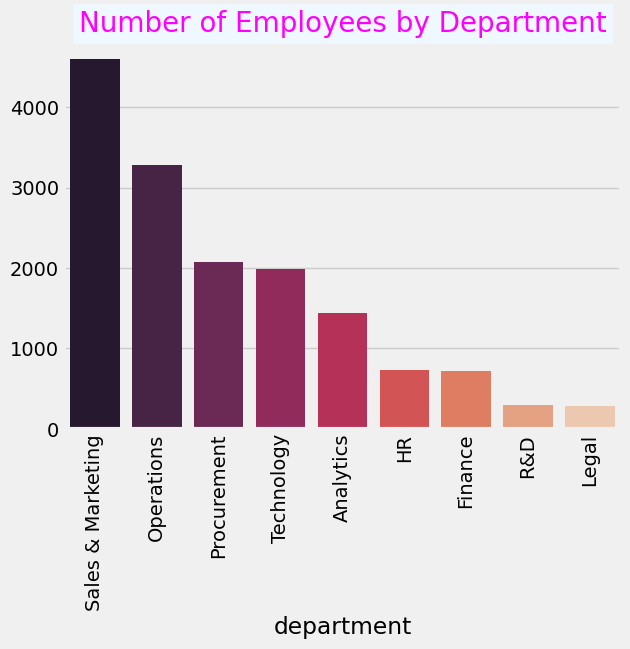

In [41]:
plt.style.use("fivethirtyeight")
chart=sns.countplot(x='department',data=df,palette='rocket', order = df['department'].value_counts().index)
plt.title("Number of Employees by Department",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta')
plt.xticks(rotation=90)
plt.ylabel("")
plt.show();

C:\Users\nadin\AppData\Local\Temp\ipykernel_32364\2898486664.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart=sns.countplot(x='education',data=df,palette='rocket', order = df['education'].value_counts().index)


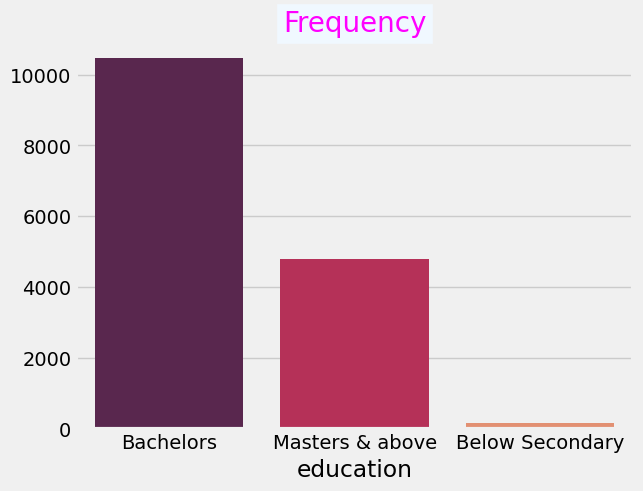

In [42]:
plt.style.use("fivethirtyeight")
chart=sns.countplot(x='education',data=df,palette='rocket', order = df['education'].value_counts().index)
plt.title("Frequency",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta')
plt.ylabel("")
plt.show();

C:\Users\nadin\AppData\Local\Temp\ipykernel_32364\2099174841.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  chart=sns.countplot(x='recruitment_channel',data=df,palette='rocket', order = df['recruitment_channel'].value_counts().index)


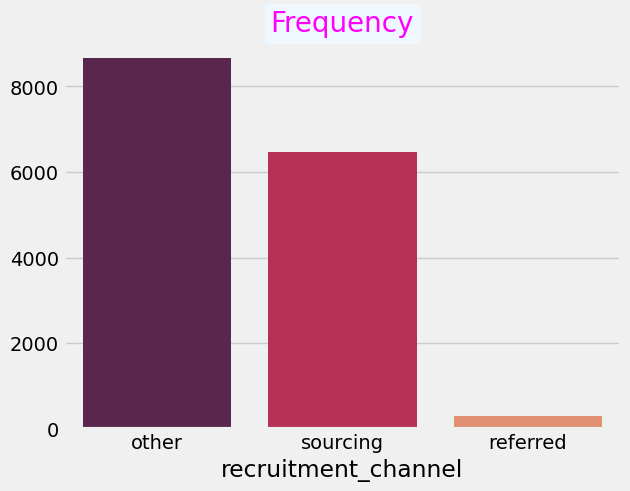

In [43]:
plt.style.use("fivethirtyeight")
chart=sns.countplot(x='recruitment_channel',data=df,palette='rocket', order = df['recruitment_channel'].value_counts().index)
plt.title("Frequency",
          fontsize='20',
          backgroundcolor='AliceBlue',
          color='magenta')
plt.ylabel("")
plt.show();

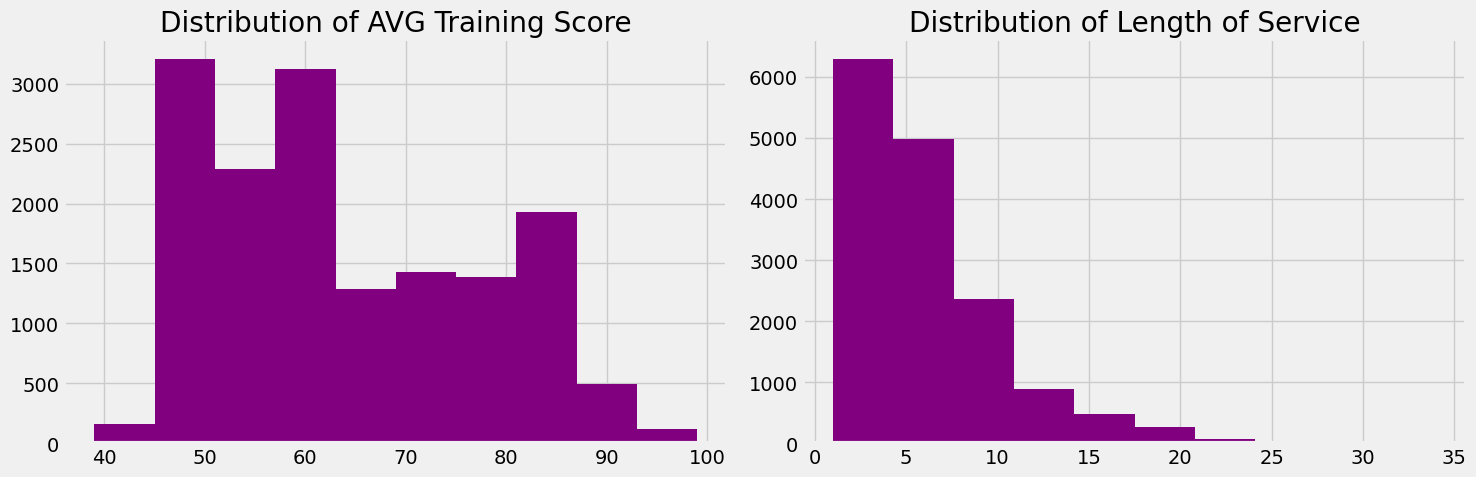

In [44]:
plt.style.use("fivethirtyeight")
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(15,5))
palette_color = sns.color_palette('rocket')
ax[0].hist(x=df['avg_training_score'],color='purple')
ax[0].set_title("Distribution of AVG Training Score")
ax[1].hist(x=df['length_of_service'], color='purple')
ax[1].set_title("Distribution of Length of Service")
plt.tight_layout();

In [45]:
df_copy = df.copy()


In [46]:
df.head()


,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score
1,HR,region_4,Bachelors,f,other,1,31,3.0,5,0,0,51
2,Sales & Marketing,region_13,Bachelors,m,other,1,31,1.0,4,0,0,47
3,Procurement,region_2,Bachelors,f,other,3,31,2.0,9,0,0,65
4,Finance,region_29,Bachelors,m,sourcing,1,30,4.0,7,0,0,61
5,Procurement,region_7,Bachelors,m,sourcing,1,36,3.0,2,0,0,68


In [47]:
df = pd.get_dummies(df,columns=['department'])


In [48]:
df = pd.get_dummies(df,columns=['gender','education','recruitment_channel'])


In [49]:
df.drop(columns=['region'], inplace=True)


# Phase 4: Data Preprocessing & Modeling


In [105]:
from sklearn.preprocessing import MinMaxScaler
minmax = MinMaxScaler()
df[df.columns] = minmax.fit_transform(df)
df = df.reset_index(drop=True)
df.head()


,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met_more_than_80,awards_won,avg_training_score,department_Analytics,department_Finance,department_HR,...,department_Sales & Marketing,department_Technology,gender_f,gender_m,education_Bachelors,education_Below Secondary,education_Masters & above,recruitment_channel_other,recruitment_channel_referred,recruitment_channel_sourcing
0,0.00,0.275,0.50,0.121212,0.0,0.0,0.200000,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.00,0.275,0.00,0.090909,0.0,0.0,0.133333,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
2,0.25,0.275,0.25,0.242424,0.0,0.0,0.433333,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.00,0.250,0.75,0.181818,0.0,0.0,0.366667,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.00,0.400,0.50,0.030303,0.0,0.0,0.483333,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0


In [106]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# numeric columns
num_cols = ['no_of_trainings', 'age', 'length_of_service', 'avg_training_score']  

# categorical columns
cat_cols = ['department', 'region', 'education', 'recruitment_channel']  # example

# numeric transformer with MinMaxScaler
numeric_transformer = Pipeline(steps=[
    ("scaler", MinMaxScaler())  # <-- replaces your manual scaling
])

# categorical transformer
categorical_transformer = Pipeline(steps=[
    ("encoder", OneHotEncoder(handle_unknown="ignore",  sparse_output=False))
])

# column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)


## PCA for Dimensionality Reduction


In [107]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(df)

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

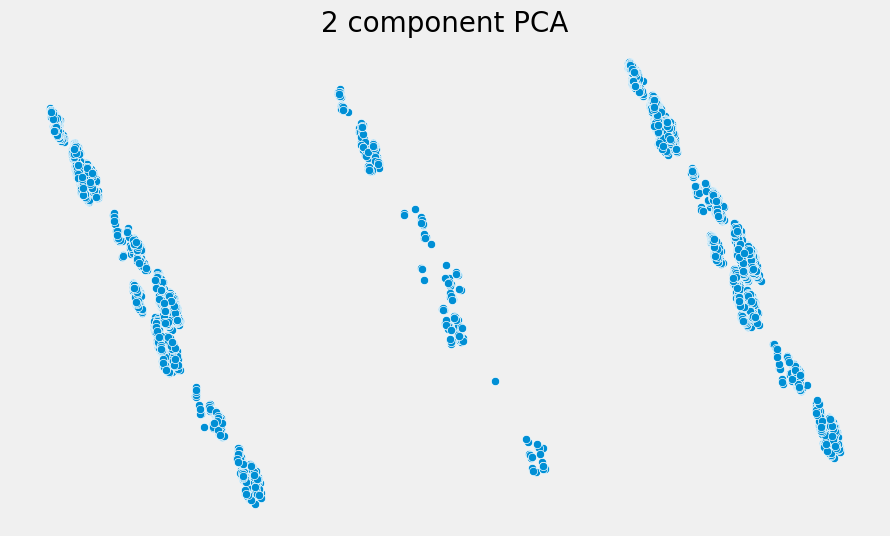

In [108]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.scatterplot(data=principalDf, x='principal component 1', y='principal component 2', ax=ax)

ax.yaxis.set_visible(False)
ax.xaxis.set_visible(False)
ax.spines[:].set_visible(False)
ax.set_xlabel('Principal Component 1', fontsize=15)
ax.set_ylabel('Principal Component 2', fontsize=15)
ax.set_title('2 component PCA', fontsize = 20)
plt.show()

In [109]:
from sklearn.ensemble import IsolationForest

# Detect outliers
iso = IsolationForest(contamination=0.05, random_state=42)  # 5% of data as outliers
outlier_pred = iso.fit_predict(principalComponents)

# outlier_pred == 1 → inlier, -1 → outlier
mask_inliers = outlier_pred == 1

# Keep only inliers
X_clean = principalComponents[mask_inliers]


## Clustering Models & Evaluation


In [100]:
# Evaluate clustering with multiple metrics
def evaluate_clustering(X, labels):
    return {
        "Silhouette": silhouette_score(X, labels),
        "Davies-Bouldin": davies_bouldin_score(X, labels),
        "Calinski-Harabasz": calinski_harabasz_score(X, labels)
    }


  **K-Means Clustering**


In [110]:
kmeans_results = []

for k in range(2, 13):
    model = KMeans(n_clusters=k,random_state=42, n_init='auto')
    model.fit(principalComponents)
    scores = evaluate_clustering(principalComponents, model.labels_)
    scores["k"] = k
    kmeans_results.append(scores)

kmeans_df = pd.DataFrame(kmeans_results)
kmeans_df

,Silhouette,Davies-Bouldin,Calinski-Harabasz,k
0,0.536944,0.856793,15562.070315,2
1,0.570703,0.657013,19435.704927,3
2,0.649865,0.483241,34367.477097,4
3,0.678197,0.415371,41880.567164,5
4,0.701130,0.378897,56312.976442,6
5,0.648651,0.493902,53605.450121,7
6,0.623694,0.518203,59584.650103,8
7,0.630678,0.527567,64387.275968,9
8,0.639978,0.491424,63746.596810,10
9,0.655498,0.436010,71520.659784,11


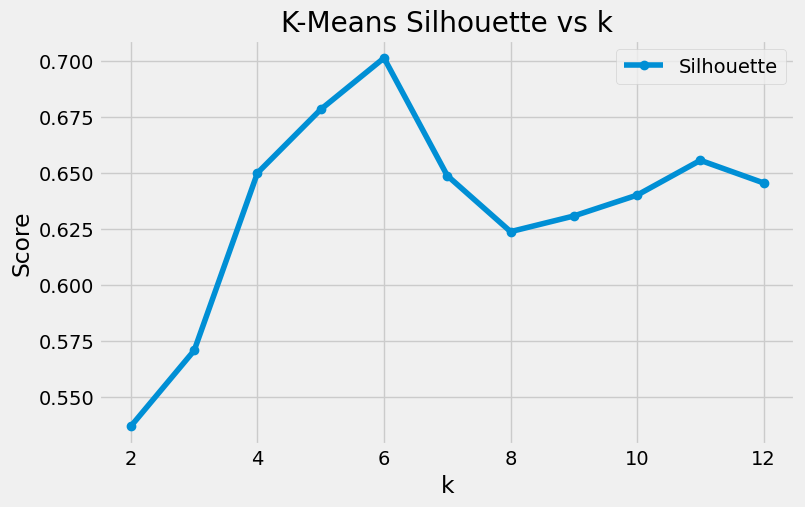

In [111]:
plt.figure(figsize=(8,5))
plt.plot(kmeans_df["k"], kmeans_df["Silhouette"], marker='o', label="Silhouette")
plt.xlabel("k")
plt.ylabel("Score")
plt.title("K-Means Silhouette vs k")
plt.grid(True)
plt.legend()
plt.show()


In [112]:
best_k = kmeans_df.sort_values("Silhouette", ascending=False).iloc[0]["k"]
best_k = int(best_k)

kmeans_final = KMeans(n_clusters=best_k, random_state=42, init="k-means++", n_init=50)
kmeans_labels = kmeans_final.fit_predict(principalComponents)

kmeans_scores = evaluate_clustering(principalComponents, kmeans_labels)
best_k, kmeans_scores


(6,
 {'Silhouette': np.float64(0.7011463156597675),
  'Davies-Bouldin': np.float64(0.37902190022925203),
  'Calinski-Harabasz': np.float64(56313.202517771875)})

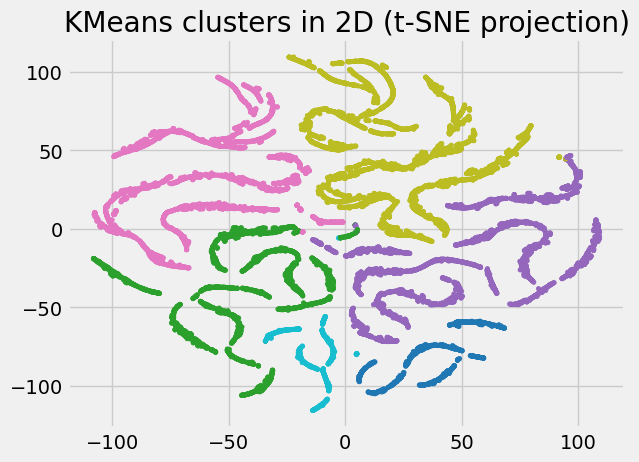

In [83]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(principalComponents)

plt.scatter(X_embedded[:,0], X_embedded[:,1], c=kmeans_labels, cmap='tab10', s=10)
plt.title("KMeans clusters in 2D (t-SNE projection)")
plt.show()


**Hierarchical Clustering**

In [113]:
# Hierarchical Clustering - alternative clustering method
agg = AgglomerativeClustering(n_clusters=best_k, linkage='complete')
agg_labels = agg.fit_predict(principalComponents)

agg_scores = evaluate_clustering(principalComponents, agg_labels)
agg_scores


{'Silhouette': np.float64(0.5992005375205212),
 'Davies-Bouldin': np.float64(0.5748711659471585),
 'Calinski-Harabasz': np.float64(40818.58505808829)}

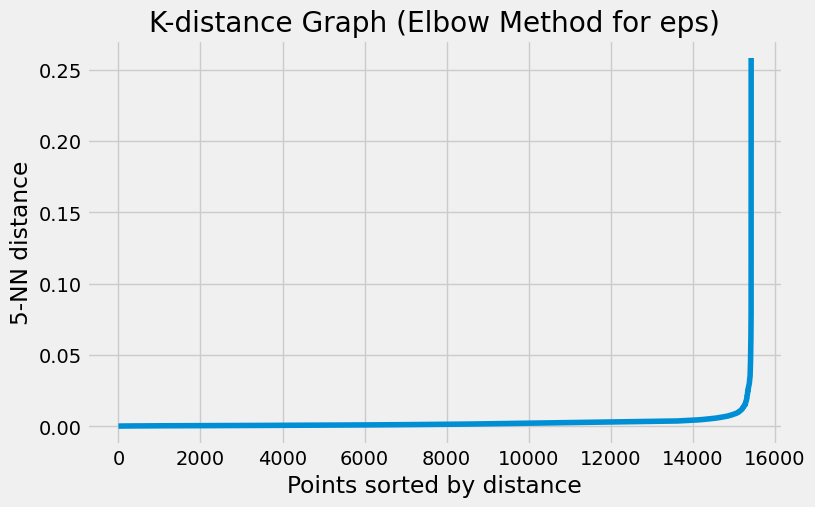

In [85]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# choose k = min_samples (start with 5)
k = 5

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(principalComponents)
distances, indices = neighbors_fit.kneighbors(principalComponents)

# distances to the k-th nearest neighbor
k_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(8, 5))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"{k}-NN distance")
plt.title("K-distance Graph (Elbow Method for eps)")
plt.grid(True)
plt.show()


In [86]:
#DBSCAN Clustering - density-based method, removes noise points
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_clean)

# remove noise for evaluation
mask = dbscan_labels != -1

dbscan_scores = evaluate_clustering(X_clean[mask], dbscan_labels[mask])
dbscan_scores


{'Silhouette': np.float64(0.5719585073905532),
 'Davies-Bouldin': np.float64(0.7883618173475148),
 'Calinski-Harabasz': np.float64(17465.707902201622)}

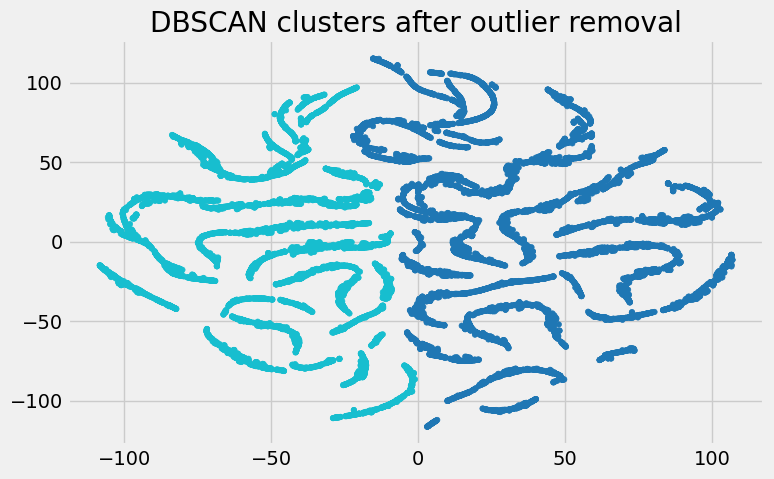

In [87]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_clean)

plt.figure(figsize=(8,5))
plt.scatter(X_embedded[:,0], X_embedded[:,1], c=dbscan_labels, cmap='tab10', s=15)
plt.title("DBSCAN clusters after outlier removal")
plt.show()

## Model Selection Summary


In [88]:
# Compare clustering models and select the best
results = pd.DataFrame([
    {"Model": "KMeans", **kmeans_scores},
    {"Model": "Hierarchical", **agg_scores},
    {"Model": "DBSCAN", **dbscan_scores}
])

results

,Model,Silhouette,Davies-Bouldin,Calinski-Harabasz
0,KMeans,0.701146,0.379022,56313.202518
1,Hierarchical,0.599201,0.574871,40818.585058
2,DBSCAN,0.571959,0.788362,17465.707902


## Save Final Model


In [89]:
# Save final pipeline including preprocessing, PCA, and best clustering model

# go up one directory from Notebooks/
MODEL_DIR = os.path.join("..", "Model")

os.makedirs(MODEL_DIR, exist_ok=True)

model_path = os.path.join(MODEL_DIR, "final_clustering_model.pkl")

final_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("pca", pca),
    ("clustering", kmeans_final)
])

joblib.dump(final_pipeline, model_path)
print(f"Final model saved at: {model_path}")


Final model saved at: ..\Model\final_clustering_model.pkl


#### Phase 5: Critical Analysis 